In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.ticker as mticker
import geopy.distance

# read in excel data with particle data w/ sheet for each year
xl_file = "/Volumes/KeithSSD/ChesapeakeMicrobiome/data/particle_backtracking_data/Particle_Data.xlsx"
assert os.path.exists(xl_file)
unformatted_df1 = pd.read_excel(xl_file, sheet_name='2015')
unformatted_df2 = pd.read_excel(xl_file, sheet_name='2016')

# read in a file of metadata
env_data_file = "/Volumes/KeithSSD/ChesapeakeMicrobiome/data/environmental_raw_data/merged_paired_water_quality_data.txt"
env_data = pd.read_csv(env_data_file, sep="\t").rename(columns={'Station':"StationName"})

# fix the station name format to match particle data
env_data['StationName'] = env_data['StationName'].str.replace(".", "")

# make a lookup table or total depth and geooposition
stat_latlon = env_data[['StationName', 'Latitude', 'Longitude', 'TotalDepth']].groupby('StationName').agg('mean')
stat_latlon['TotalDepth'] = stat_latlon['TotalDepth'].round().astype(int)
stat_latlon.head()

,Latitude,Longitude,TotalDepth
StationName,,,
CB22,39.34873,-76.17579,12
CB31,39.24950,-76.24050,14
CB32,39.16369,-76.30631,12
CB33C,38.99596,-76.35967,25
CB41C,38.82593,-76.39945,32


In [2]:
# divide up a given excel sheet into the many backtracking simulation objects contained within
# reformat each so that the header inforation is broadcast down across every row (particle)
def prep_particle_chunk(sample_pt_i, sample_pts, stat_latlon, particle_data, index_range_i):
    one_sample = sample_pts.loc[sample_pt_i, :].to_dict()
    one_sample['StatLat'] = stat_latlon.loc[one_sample['StationName'], 'Latitude']
    one_sample['StatLon'] = stat_latlon.loc[one_sample['StationName'], 'Longitude']
    one_sample['StatTotDepth'] = stat_latlon.loc[one_sample['StationName'], 'TotalDepth']*-1
    one_sample['DepthName'] *= -1
    origin_cols = pd.DataFrame({p_i: one_sample for p_i in index_range_i}).T
    one_section = particle_data.loc[index_range_i, :].copy()
    particle_sub = pd.concat((one_section, origin_cols), axis=1, sort=1, verify_integrity=1)
    return particle_sub.copy()

This first portion is to use the particle data from the bottom samples and decide how to group samples via a location set covering optimization problem. 

In [3]:
# the first transect year
particles_2016 = unformatted_df2.copy()

# these are the station location (header) rows
sample_pts = particles_2016.iloc[: , :6].dropna()

# pull out this data and add the right column names 
particle_data = particles_2016.iloc[1:, 6:].dropna()
particle_data.columns = ['y_km', 'x_km', 'lat', 'lon', 'depth']
particle_data = particle_data.apply(pd.to_numeric, axis=1)

# each header row above is followed by 300 rows that are point locations
index_ranges = {i:list(range(i+1,i+301)) for i in sample_pts.index}

# convert longitude
particle_data['lon'] = particle_data['lon'] - 360

# get a complete list of bottom water samples, but also index them by station
lowest_points, subset_to_use = {}, set()
for s in sample_pts.StationName.unique():
    sample_sub = sample_pts.loc[sample_pts.StationName == s, :]
    depth_sub = sample_sub.loc[sample_sub.DepthName >= sample_sub.DepthName.max()-2, :]
    # print the number of different depths sampled and then print the subset you are using 
    print(s, sample_sub.DepthName.max(), len(sample_sub.DepthName.unique()), depth_sub.DepthName.unique())
    lowest_points[s] = (list(depth_sub.index), len(depth_sub.DateMMDDYY.unique()))
    subset_to_use.update(list(depth_sub.index))

assert set([j for i in index_ranges.values() for j in i]) == set(particle_data.index)

# divide up sheet into individual simulation dataframes
particle_chunks = {}
for s_p, ir_i in list(index_ranges.items()):
    particle_chunks[s_p] = prep_particle_chunk(s_p, sample_pts, stat_latlon, particle_data, ir_i)

# show how many samples there were and how many you are analyzing
print(len(index_ranges), len(subset_to_use))

# show the format of each `particle chunk`
list(particle_chunks.values())[0].head()


CB33C 24.0 17 [22. 24.]
CB22 11.0 1 [11.]
CB43C 27.0 2 [27. 26.]
CB44 31.0 1 [31.]
CB51 33.0 1 [33.]
CB52 29.0 1 [29.]
CB53 25.0 1 [25.]
CB54 25.0 1 [25.]
CB71 17.0 2 [16. 17.]
CB62 9.0 1 [9.]
CB63 11.0 2 [10. 11.]
CB72 20.0 2 [20. 19.]
CB64 9.0 2 [8. 9.]
CB74 13.0 1 [13.]
CB31 13.0 1 [13.]
CB32 10.0 1 [10.]
CB41C 31.0 1 [31.]
CB42C 26.0 1 [26.]
CB61 11.0 1 [11.]
CB73 12.0 1 [12.]
75 47


,y_km,x_km,lat,lon,depth,Samples,DepthName,DateMMDDYY,Time,StationName,CollectionAgency,StatLat,StatLon,StatTotDepth
1,907451.69,4334940.5,39.071159,-76.29114,-9.697164,SB062716TAWCSCB33CD1BR2TR1I80,-1,62716,09:13:00,CB33C,Preheim,38.996,-76.3597,-25
2,911187.13,4331585.0,39.039276,-76.25012,-0.102223,SB062716TAWCSCB33CD1BR2TR1I80,-1,62716,09:13:00,CB33C,Preheim,38.996,-76.3597,-25
3,896647.69,4324071.0,38.978493,-76.42194,-2.098320,SB062716TAWCSCB33CD1BR2TR1I80,-1,62716,09:13:00,CB33C,Preheim,38.996,-76.3597,-25
4,909035.63,4327793.5,39.006233,-76.27716,-4.127914,SB062716TAWCSCB33CD1BR2TR1I80,-1,62716,09:13:00,CB33C,Preheim,38.996,-76.3597,-25
5,897784.50,4315252.0,38.898766,-76.41397,-6.030720,SB062716TAWCSCB33CD1BR2TR1I80,-1,62716,09:13:00,CB33C,Preheim,38.996,-76.3597,-25


In [4]:
"""# here is where we make the "distance matrix" for the objective function of our optimizatiton problem
ptcle_stat_distmat = pd.DataFrame(index=list(lowest_points.keys()), 
                                  columns=list(lowest_points.keys()))

# function for geoposition distances
horiz_dist = lambda x: geopy.distance.distance((x[0], x[1]), (x[2], x[3])).km

# operate pairwise over samples
for s_stat in ptcle_stat_distmat.columns:
    for p_stat in ptcle_stat_distmat.index:    
        
        # these are the simulations for the station in the rows
        stat_p_ixs = lowest_points[p_stat][0]
        
        # make a list of each of the dataframes full of particle locations
        stat_p_ixs = [particle_chunks[s_p].loc[:, ['lat', 'lon']] for s_p in stat_p_ixs]
        
        # unpack all the point geoposiitons for all simulations into one list
        stat_p_locs = [list(stat_p.loc[idx,['lat', 'lon']]) for stat_p in stat_p_ixs for idx in stat_p.index]

        # take the location of the station in the columns
        stat_s_loc = list(stat_latlon.loc[s_stat, :])
        
        # use map to calculate all the horizontal positions
        arg_set = [(stat_s_loc[0], stat_s_loc[1], sx[0], sx[1]) for sx in stat_p_locs]
        dist_set = np.array(list(map(horiz_dist, arg_set)))
        
        # calculate the average distance between particles tracked from p_stat to s_stat
        ptcle_stat_distmat.loc[p_stat, s_stat] = dist_set.mean()
        print("{} {} {:.2f}".format(s_stat, p_stat, dist_set.mean()))
"""

'# here is where we make the "distance matrix" for the objective function of our optimizatiton problem\nptcle_stat_distmat = pd.DataFrame(index=list(lowest_points.keys()), \n                                  columns=list(lowest_points.keys()))\n\n# function for geoposition distances\nhoriz_dist = lambda x: geopy.distance.distance((x[0], x[1]), (x[2], x[3])).km\n\n# operate pairwise over samples\nfor s_stat in ptcle_stat_distmat.columns:\n    for p_stat in ptcle_stat_distmat.index:    \n        \n        # these are the simulations for the station in the rows\n        stat_p_ixs = lowest_points[p_stat][0]\n        \n        # make a list of each of the dataframes full of particle locations\n        stat_p_ixs = [particle_chunks[s_p].loc[:, [\'lat\', \'lon\']] for s_p in stat_p_ixs]\n        \n        # unpack all the point geoposiitons for all simulations into one list\n        stat_p_locs = [list(stat_p.loc[idx,[\'lat\', \'lon\']]) for stat_p in stat_p_ixs for idx in stat_p.index]\n\n 

In [5]:
"""from itertools import combinations

# this function makes all possible groups size 1 to 5 
grps_by_size = {}
all_grps = set()
for grp_size in range(1,5):
    gps_of_size_i = combinations(list(ptcle_stat_distmat.index), grp_size)
    gps_of_srt_i = [tuple(sorted(list(j))) for j in gps_of_size_i]
    assert len(gps_of_srt_i) == len(set(gps_of_srt_i))
    print("Groups of size {}: {} {}".format(grp_size, len(gps_of_srt_i), gps_of_srt_i[:3]))
    grps_by_size[grp_size] = gps_of_srt_i
    all_grps.update(gps_of_srt_i)

print(len(all_grps))

other_cols =  ['F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']
solver_sheet = pd.DataFrame(index=range(1, len(all_grps)+1), columns=['Q', 'A', 'B', 'C', 'D', 'E']+other_cols)

counter = 0
for gs_, gs_i in grps_by_size.items():
    print(gs_)
    for g_i in gs_i:
        i = solver_sheet.index[counter]
        solver_sheet.loc[i, 'Q'] = gs_
        solver_sheet.loc[i, 'A'] = g_i
        solver_sheet.loc[i, 'B'] = 0
        inter_group_dist = 0
        for p_stat in g_i:
            for s_stat in g_i:
                inter_group_dist += ptcle_stat_distmat.loc[p_stat, s_stat]
        solver_sheet.loc[i, 'C'] = inter_group_dist
        counter += 1
"""

'from itertools import combinations\n\n# this function makes all possible groups size 1 to 5 \ngrps_by_size = {}\nall_grps = set()\nfor grp_size in range(1,5):\n    gps_of_size_i = combinations(list(ptcle_stat_distmat.index), grp_size)\n    gps_of_srt_i = [tuple(sorted(list(j))) for j in gps_of_size_i]\n    assert len(gps_of_srt_i) == len(set(gps_of_srt_i))\n    print("Groups of size {}: {} {}".format(grp_size, len(gps_of_srt_i), gps_of_srt_i[:3]))\n    grps_by_size[grp_size] = gps_of_srt_i\n    all_grps.update(gps_of_srt_i)\n\nprint(len(all_grps))\n\nother_cols =  [\'F\', \'G\', \'H\', \'I\', \'J\', \'K\', \'L\', \'M\', \'N\', \'O\']\nsolver_sheet = pd.DataFrame(index=range(1, len(all_grps)+1), columns=[\'Q\', \'A\', \'B\', \'C\', \'D\', \'E\']+other_cols)\n\ncounter = 0\nfor gs_, gs_i in grps_by_size.items():\n    print(gs_)\n    for g_i in gs_i:\n        i = solver_sheet.index[counter]\n        solver_sheet.loc[i, \'Q\'] = gs_\n        solver_sheet.loc[i, \'A\'] = g_i\n        solve

In [6]:
"""# this artifically narrows the search field to the most likely groups of each size
limits_by_size = {2:50, 3:60, 4:60}

best_indexes = set()
best_indexes.update(list(solver_sheet.loc[solver_sheet.Q == 1, 'A']))
print(len(best_indexes), 'best_indexes')

for grp_size, size_lim in limits_by_size.items():
    subsolver = solver_sheet[solver_sheet.Q == grp_size]
    remaining_groups = set(subsolver.A)
    added_groups  = set()
    while len(added_groups) < size_lim:
        # see whats remaining among all 
        avail_bool = subsolver.A.isin(remaining_groups)
        # make into a set 
        remaining_size_i = set(subsolver[avail_bool].A)
        print(len(remaining_size_i), "1x")
        # find the best single group
        best_avail = subsolver[avail_bool].sort_values(by='C')
        best_grp = best_avail.iloc[0, 1]
        # set up a set of the remaining stations 
        coherency_ = set(ptcle_stat_distmat.index) - set(list(best_grp))
        # set up a set of the stations pulled into this set group
        coherent_group = set([best_grp])
        # make the best group unavailable
        remaining_size_i.remove(best_grp)
        remaining_size_i = list(filter(lambda x: len(set(x) - coherency_) == 0, remaining_size_i))
        print(len(remaining_size_i), len(coherent_group), "2x")
        while len(remaining_size_i) > 0:
            # remove anything with any stations from the best group(s)
            print(len(remaining_size_i), "3x")
            # resort and pull the best
            avail_bool = subsolver.A.isin(remaining_size_i)
            best_avail = subsolver[avail_bool].sort_values(by='C')
            best_remaining = best_avail.iloc[0, 1]
            # add it to the local set group
            coherent_group.update([best_remaining])
            # make the stations added unavailable
            for br in best_remaining:
                coherency_.remove(br)
            remaining_size_i.remove(best_remaining)
            remaining_size_i = list(filter(lambda x: len(set(x) - coherency_) == 0, remaining_size_i))
            print(len(remaining_size_i), len(coherent_group), "4x")
        
        if len(coherency_) > 0:
            coherent_group.update([tuple(sorted(coherency_))])
        print(len(remaining_size_i), len(coherent_group), "5x")  
        
        added_groups.update(coherent_group)
        print(len(added_groups), 'added_groups out of', size_lim)
        for cg in coherent_group:
            if cg in remaining_groups:
                remaining_groups.remove(cg)
        print(len(remaining_groups), 'remaining_groups')
    
    best_indexes.update(added_groups)

print(np.unique([len(i) for i in best_indexes], return_counts=True))
print(best_indexes - set(solver_sheet.A))
solver_sheet2 = solver_sheet.copy().loc[solver_sheet.A.isin(best_indexes), :]
print(len(solver_sheet2))
solver_sheet2 = solver_sheet2.sort_values(by=['Q', 'A'])
solver_sheet2 = solver_sheet2.rename(index={old_idx:ix+1 for ix, old_idx in enumerate(solver_sheet2.index)})

solver_sheet2.drop('Q', axis=1, inplace=True)
# the objective function is easy, its sumproduct(A, B) 
solver_sheet2.loc[1, 'D'] = 'Objective Function'
solver_sheet2.loc[2, 'D'] = "=SUMPRODUCT(B:B,C:C)"
solver_sheet2.loc[3, 'D'] = 'Group Creation Limit'
solver_sheet2.loc[4, 'D'] = '=SUM(B:B)'
solver_sheet2.loc[4, 'E'] = '==' 
solver_sheet2.loc[4, 'F'] = '6' 
solver_sheet2.loc[5, 'D'] = 'Group Constraints'

for st_ix, stat in enumerate(sorted(ptcle_stat_distmat.index)):
    solver_sheet2.loc[6+st_ix, 'D'] = stat
    bcells = [str(idx) for idx in solver_sheet2.index if stat in solver_sheet2.loc[idx, 'A']]
    solver_sheet2.loc[6+st_ix, 'E'] = "=B" + "+B".join(bcells)


empty_cols = solver_sheet2.columns[solver_sheet2.isnull().sum() == len(solver_sheet2)]
print(empty_cols)
solver_sheet3 = solver_sheet2.drop(empty_cols, axis=1)
solver_sheet3.to_csv("/Volumes/KeithSSD/ChesapeakeMicrobiome/data/particle_backtracking_data/station_group_opto.csv", header=False, 
                    index=False)"""

'# this artifically narrows the search field to the most likely groups of each size\nlimits_by_size = {2:50, 3:60, 4:60}\n\nbest_indexes = set()\nbest_indexes.update(list(solver_sheet.loc[solver_sheet.Q == 1, \'A\']))\nprint(len(best_indexes), \'best_indexes\')\n\nfor grp_size, size_lim in limits_by_size.items():\n    subsolver = solver_sheet[solver_sheet.Q == grp_size]\n    remaining_groups = set(subsolver.A)\n    added_groups  = set()\n    while len(added_groups) < size_lim:\n        # see whats remaining among all \n        avail_bool = subsolver.A.isin(remaining_groups)\n        # make into a set \n        remaining_size_i = set(subsolver[avail_bool].A)\n        print(len(remaining_size_i), "1x")\n        # find the best single group\n        best_avail = subsolver[avail_bool].sort_values(by=\'C\')\n        best_grp = best_avail.iloc[0, 1]\n        # set up a set of the remaining stations \n        coherency_ = set(ptcle_stat_distmat.index) - set(list(best_grp))\n        # set up a

This is where just some summary statistics go

In [7]:
horiz_dist = lambda x: geopy.distance.distance((x[0], x[1]), (x[2], x[3])).km

def summarize_chunk(particle_sub):
    # get individual vertical and lateral distances 
    pos_cols = ['lat', 'lon', 'StatLat', 'StatLon']
    particle_sub['horiz_dist'] = particle_sub[pos_cols].apply(horiz_dist, axis=1)
    particle_sub['vert_dist'] = particle_sub['DepthName'] - particle_sub['depth']
    # container for summary statistics
    sub_summary = {}
    
    # determine whether upper or lower water column
    pct_total_depth = abs(particle_sub['DepthName'].unique()) / abs(particle_sub['StatTotDepth'].unique())
    assert len(pct_total_depth) == 1
    
    # if lower water columns
    if pct_total_depth[0] >= 0.75:
        sub_summary['watercolumnposition'] = 'Bottom'
        travellers = list((particle_sub['depth'] >= (particle_sub['StatTotDepth']/4)))
        sub_summary['vertical_mixing_pct'] = travellers.count(True) / float(len(travellers))
    elif pct_total_depth[0] <= 0.25:
        sub_summary['watercolumnposition'] = 'Top'
        travellers = list((particle_sub['depth'] <= (particle_sub['StatTotDepth']/2)))
        sub_summary['vertical_mixing_pct'] = travellers.count(True) / float(len(travellers))
    else:
        sub_summary['watercolumnposition'] = 'Mid'
        sub_summary['vertical_mixing_pct'] = np.nan
    
    sub_summary['sum_horiz_dist'] = particle_sub['horiz_dist'].sum()
    sub_summary['sum_vert_dist'] = abs(particle_sub['vert_dist']).sum()
    sub_summary['sum_downwelling'] = particle_sub.loc[particle_sub.vert_dist < 0, 'vert_dist'].sum()
    sub_summary['sum_upwelling'] = particle_sub.loc[particle_sub.vert_dist > 0, 'vert_dist'].sum()
    sub_summary['north_lim'] = np.percentile(particle_sub.lat, 75) - particle_sub.StatLat.unique()[0]
    sub_summary['south_lim'] = np.percentile(particle_sub.lat, 25) - particle_sub.StatLat.unique()[0]
    sub_summary['east_lim'] = np.percentile(particle_sub.lon, 75) - particle_sub.StatLon.unique()[0]
    sub_summary['west_lim'] = np.percentile(particle_sub.lon, 25) - particle_sub.StatLon.unique()[0]
    sub_summary['up_lim'] = np.percentile(particle_sub.depth, 75) - particle_sub.DepthName.unique()[0]
    sub_summary['down_lim'] = np.percentile(particle_sub.depth, 25) - particle_sub.DepthName.unique()[0]
    sub_summary['total_depth'] = particle_sub['StatTotDepth'].max()
    return sub_summary


In [8]:
def summarize_particle_year(unformatted_df):
    # the first six columns are date time depth station collection agency 
    sample_pts = unformatted_df.iloc[: , :6].dropna()
    # pull out this data and add the right column names 
    particle_data = unformatted_df.iloc[1:, 6:].dropna()
    particle_data.columns = ['y_km', 'x_km', 'lat', 'lon', 'depth']
    particle_data = particle_data.apply(pd.to_numeric, axis=1)
    # longitude is wrong
    particle_data['lon'] = particle_data['lon'] - 360
    print(particle_data.head())
    # the following 300 rows are the point locations 
    index_ranges = {i:list(range(i+1,i+301)) for i in sample_pts.index}
    
    assert set([j for i in index_ranges.values() for j in i]) == set(particle_data.index)

    particle_chunks = {}
    for s_p, ir_i in index_ranges.items():
        particle_chunks[s_p] = prep_particle_chunk(s_p, sample_pts, stat_latlon, particle_data, ir_i)
    
    print(particle_chunks[s_p].head())
    print(len(particle_chunks), sum([len(i) for i in particle_chunks.values()]))
    
    p_summary = {}
    for sp_i, pcdf in particle_chunks.items():
        p_summary[sp_i] = summarize_chunk(pcdf)

    column_order = ['watercolumnposition', 'vertical_mixing_pct', 'total_depth', 'sum_horiz_dist', 'sum_vert_dist', 
                    'sum_downwelling', 'sum_upwelling', 'north_lim', 'south_lim', 'east_lim', 'west_lim', 
                    'up_lim', 'down_lim']
    
    psum_df = pd.DataFrame(p_summary).T.loc[:, column_order]
    samples_summarized = pd.concat((sample_pts, psum_df), axis=1, sort=1, verify_integrity=1)    
    midsection = (samples_summarized.DepthName < 20.) & (samples_summarized.DepthName > 3.)
    cb33midsection = (samples_summarized.StationName == 'CB33C') & midsection
    samples_summarized.loc[cb33midsection, 'watercolumnposition'] = 'Mid'
    samples_summarized.loc[cb33midsection, 'vertical_mixing_pct'] = np.nan
    return samples_summarized.copy(), particle_chunks

In [9]:
# this drops a simulation that had bad data (copy/paste error)
unformatted_df2_x = unformatted_df2.drop(15050, axis=0)
unformatted_df2_x = unformatted_df2_x.drop(range(15050+1,15050+301), axis=0)

particles2016, particle_chunks16 = summarize_particle_year(unformatted_df2_x.copy())

        y_km       x_km        lat       lon     depth
1  907451.69  4334940.5  39.071159 -76.29114 -9.697164
2  911187.13  4331585.0  39.039276 -76.25012 -0.102223
3  896647.69  4324071.0  38.978493 -76.42194 -2.098320
4  909035.63  4327793.5  39.006233 -76.27716 -4.127914
5  897784.50  4315252.0  38.898766 -76.41397 -6.030720
            y_km       x_km        lat       lon     depth  \
22275  951947.00  4108986.0  37.020973 -75.92120 -3.574278   
22276  959054.94  4112994.0  37.053520 -75.83917 -9.554222   
22277  943159.19  4122908.5  37.150188 -76.01141 -8.234143   
22278  965021.38  4117287.5  37.089127 -75.76971 -2.520278   
22279  962047.13  4112227.8  37.045174 -75.80615 -5.617439   

                              Samples DepthName DateMMDDYY      Time  \
22275  SB082916TAWCSCB74D13BR1TR1I246       -13      82916  09:55:00   
22276  SB082916TAWCSCB74D13BR1TR1I246       -13      82916  09:55:00   
22277  SB082916TAWCSCB74D13BR1TR1I246       -13      82916  09:55:00   
22278  SB

In [10]:
print(particles2016.columns)
vertical_mixing_df = particles2016.loc[particles2016.watercolumnposition != 'Mid', 
                                       ['StationName', 'watercolumnposition', 'vertical_mixing_pct', 'total_depth']]
vertical_mixing_df['vertical_mixing_pct'] = vertical_mixing_df['vertical_mixing_pct'].astype(np.float64)
vertical_mixing_df['total_depth'] = vertical_mixing_df['total_depth'].astype(np.float64)
vert_average = vertical_mixing_df.groupby(['StationName', 'watercolumnposition']).agg([np.mean, np.std])
print(vertical_mixing_df.loc[vertical_mixing_df.watercolumnposition == 'Bottom', 'vertical_mixing_pct'].mean())
print(vertical_mixing_df.loc[vertical_mixing_df.watercolumnposition == 'Bottom', 'vertical_mixing_pct'].std())
vert_average

Index(['Samples', 'DepthName', 'DateMMDDYY', 'Time', 'StationName',
       'CollectionAgency', 'watercolumnposition', 'vertical_mixing_pct',
       'total_depth', 'sum_horiz_dist', 'sum_vert_dist', 'sum_downwelling',
       'sum_upwelling', 'north_lim', 'south_lim', 'east_lim', 'west_lim',
       'up_lim', 'down_lim'],
      dtype='object')
0.2923809523809524
0.19010352929877933


vertical_mixing_pct           total_depth     
                                               mean       std        mean  std
StationName watercolumnposition                                               
CB22        Bottom                         0.467778  0.025019       -12.0  0.0
CB31        Bottom                         0.508333  0.011785       -14.0  0.0
CB32        Bottom                         0.366667       NaN       -12.0  NaN
CB33C       Bottom                         0.463333  0.093405       -25.0  0.0
            Top                            0.050000  0.022236       -25.0  0.0
CB41C       Bottom                         0.300000       NaN       -32.0  NaN
CB42C       Bottom                         0.266667       NaN       -28.0  NaN
CB43C       Bottom                         0.601111  0.039768       -28.0  0.0
CB44        Bottom                         0.368333  0.058926       -32.0  0.0
CB51        Bottom                         0.593333  0.094281       -34.0  0.0
CB52        Bottom                         0.128333  0.007071       -31.0  0.0
CB53        Bottom                         0.228889  0.051676       -27.0  0.0
CB54        Bottom                         0.180000  0.031798       -32.0  0.0
CB61        Bottom                         0.055000  0.007071       -12.0  0.0
CB62        Bottom                         0.094444  0.039487       -10.0  0.0
CB63        Bottom                         0.104444  0.058341       -11.0  0.0
CB64        Bottom                         0.051111  0.051027       -10.0  0.0
CB71        Bottom                         0.067778  0.062746       -18.0  0.0
CB72        Bottom                         0.307778  0.106684       -21.0  0.0
CB73        Bottom                         0.296667       NaN       -13.0  NaN
CB74        Bottom                         0.350000  0.042426       -15.0  0.0

In [11]:
particles2015, particle_chunks15 = summarize_particle_year(unformatted_df1.copy())

        y_km       x_km        lat       lon     depth
1  909285.13  4334724.0  39.068359 -76.27014 -0.926382
2  895980.38  4318600.5  38.929649 -76.43277 -8.271848
3  905129.19  4345616.0  39.168118 -76.31152 -1.692219
4  895877.88  4334220.0  39.070011 -76.42490  0.137363
5  904317.06  4328407.0  39.013931 -76.33112 -5.380552
            y_km       x_km        lat       lon     depth  \
12643  899750.81  4313213.5  38.879559 -76.39255 -5.745139   
12644  900963.50  4306095.0  38.815060 -76.38275 -8.047166   
12645  893453.31  4299034.5  38.755020 -76.47302 -8.368210   
12646  896871.88  4320334.0  38.944828 -76.42151 -5.427194   
12647  896704.19  4318109.5  38.924919 -76.42474 -6.886198   

                              Samples DepthName DateMMDDYY      Time  \
12643  SB082015TAWCSCB33CD20BR1TR1I74       -20      82015  09:56:00   
12644  SB082015TAWCSCB33CD20BR1TR1I74       -20      82015  09:56:00   
12645  SB082015TAWCSCB33CD20BR1TR1I74       -20      82015  09:56:00   
12646  SB

In [12]:
depth_index_june16 = [0, 301, 602, 903, 1204, 1505, 1806, 2107, 2408, 2709, 3010]
depth_index_july16 = [3612, 3913, 4214, 4515, 4816, 5117, 5418, 5719, 6020, 6321]
depth_index_aug16 = [12040, 12341, 12642, 12943, 13244, 13545, 13846, 14147]
depths_to_add_back = [3010] + [6321] + [14147]
depth_prof_idxs = depth_index_june16+depth_index_july16+depth_index_aug16

transect_set = [i for i in depth_prof_idxs if not i in depths_to_add_back]
particles_transect_2016 = particles2016.drop(transect_set, axis=0)
depth_profiles_2016 = particles2016.loc[depth_prof_idxs, :]
print(particles_transect_2016.shape)
print(depth_profiles_2016.shape)

(48, 19)
(29, 19)


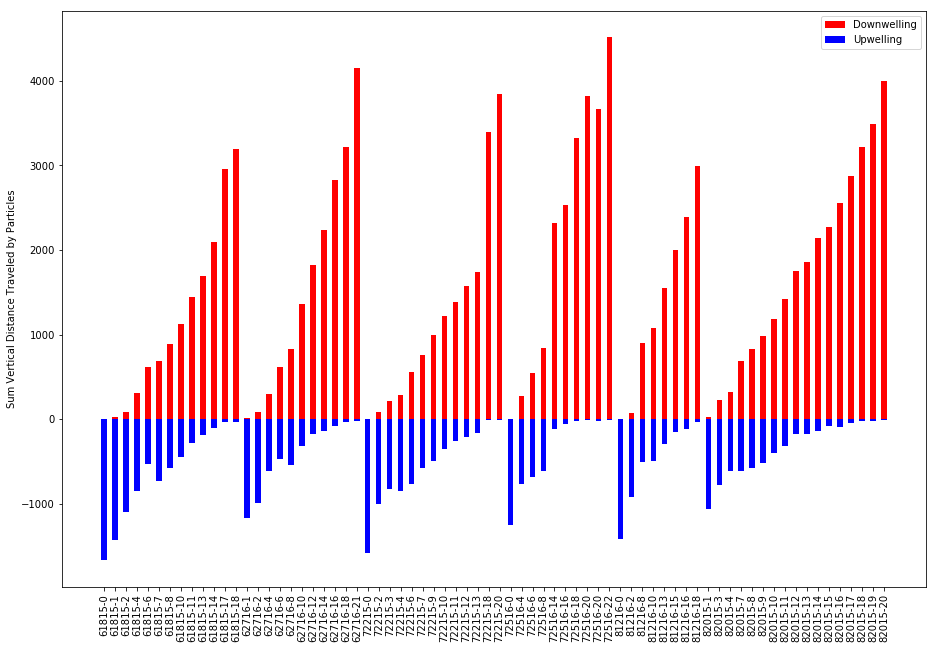

In [13]:
depth_profiles_1516 = pd.concat((particles2015, depth_profiles_2016), axis=0, sort=1, ignore_index=1)
particles1516srt =  depth_profiles_1516.sort_values(by=['DateMMDDYY', 'DepthName'])

#particles2015srt.loc[particles2015srt.index[:20], ['DateMMDDYY', 'DepthName']]

y1 = particles1516srt['sum_upwelling'].values
y2 = particles1516srt['sum_downwelling'].values
xlab  = particles1516srt[['DateMMDDYY', 'DepthName']].apply(lambda x: "-".join([str(int(x[0])), 
                                                                                str(int(x[1]))]), axis=1)

x12 = list(range(1,len(y1)+1))

fig = plt.figure(figsize=(12, 8))
ax = fig.add_axes([0,0,1,1])

ax.bar(x12, y2*-1, 0.5, label='Downwelling', bottom=[0]*len(y2), color='r')
ax.bar(x12, y1*-1, 0.5, label='Upwelling', bottom=[0]*len(y2), color='b')
ax.set_ylabel('Sum Vertical Distance Traveled by Particles')
ax.set_xticks(x12)
ax.set_xticklabels(list(xlab), rotation = 90)
#ax.set_yticks(np.arange(0, 81, 10))
ax.legend()
plt.show()


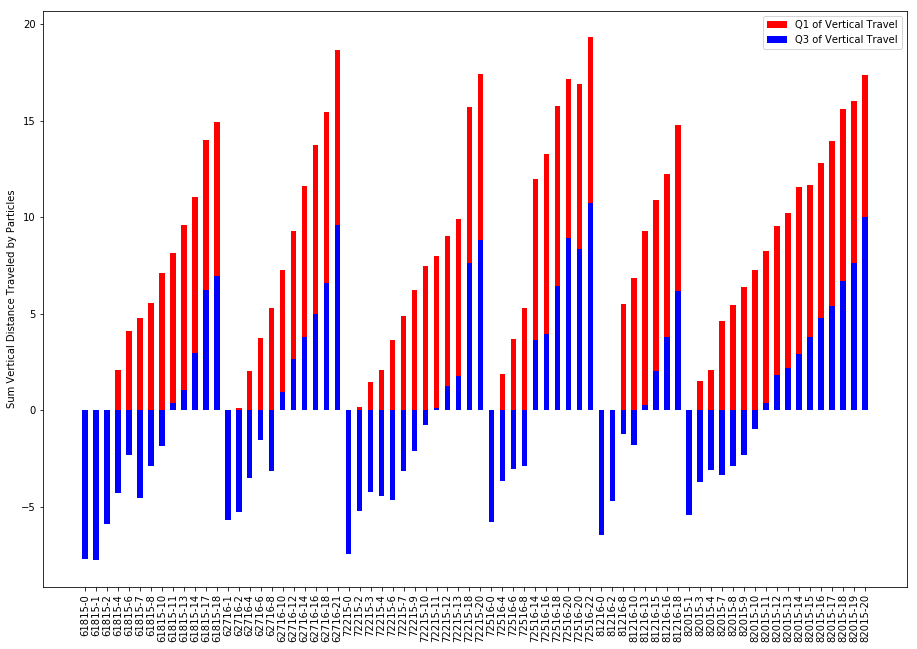

In [14]:
y1 = particles1516srt['up_lim'].values
y2 = particles1516srt['down_lim'].values
xlab  = particles1516srt[['DateMMDDYY', 'DepthName']].apply(lambda x: "-".join([str(int(x[0])), 
                                                                                str(int(x[1]))]), axis=1)

x12 = list(range(1,len(y1)+1))

fig = plt.figure(figsize=(12, 8))
ax = fig.add_axes([0,0,1,1])

ax.bar(x12, y1, 0.5, label='Q1 of Vertical Travel', bottom=[0]*len(y1), color='r')
ax.bar(x12, y2, 0.5, label='Q3 of Vertical Travel', bottom=[0]*len(y2), color='b')
ax.set_ylabel('Sum Vertical Distance Traveled by Particles')
ax.set_xticks(x12)
ax.set_xticklabels(list(xlab), rotation = 90)
#ax.set_yticks(np.arange(0, 81, 10))
ax.legend()
plt.show()


  down_lim   east_lim  north_lim  south_lim     up_lim   west_lim
0 -7.71956  0.0459625   0.100737 -0.0359955   -2.01979 -0.0436775
1 -7.76903  0.0540425  0.0905298 -0.0410737   -1.06499    -0.0398
2 -5.86897  0.0380725   0.101504 -0.0330787  0.0311961   -0.04558
3 -4.30583   0.017915   0.121242 -0.0608955    2.09917   -0.05147
4 -2.29891   0.030895  0.0730403  -0.113229    4.11048 -0.0546125


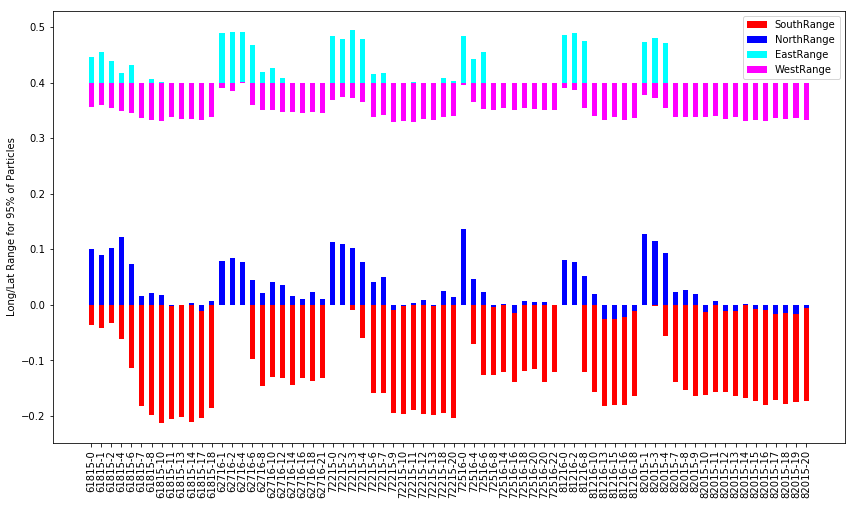

In [15]:
y1 = particles1516srt['south_lim'].values
y2 = particles1516srt['north_lim'].values
y3 = particles1516srt['east_lim'].values
y4 = particles1516srt['west_lim'].values

print(particles1516srt[[i for i in particles1516srt.columns if 'lim' in i]].head())

x12 = list(range(1,len(y1)+1))

fig = plt.figure(figsize=(11, 6))
ax = fig.add_axes([0,0,1,1])

ax.bar(x12, y1, 0.5, label='SouthRange', color='r')
ax.bar(x12, y2, 0.5, label='NorthRange', color='b')
ax.bar(x12, y3, 0.5, label='EastRange', bottom=[0.4]*len(y3), color='cyan')
ax.bar(x12, y4, 0.5, label='WestRange', bottom=[0.4]*len(y4), color='magenta')
ax.set_ylabel('Long/Lat Range for 95% of Particles')
ax.set_xticks(x12)
ax.set_xticklabels(list(xlab), rotation = 90)
#ax.set_yticks(np.arange(0, 81, 10))
ax.legend()
plt.show()
                      

Index(['Samples', 'DepthName', 'DateMMDDYY', 'Time', 'StationName',
       'CollectionAgency', 'watercolumnposition', 'vertical_mixing_pct',
       'total_depth', 'sum_horiz_dist', 'sum_vert_dist', 'sum_downwelling',
       'sum_upwelling', 'north_lim', 'south_lim', 'east_lim', 'west_lim',
       'up_lim', 'down_lim'],
      dtype='object')


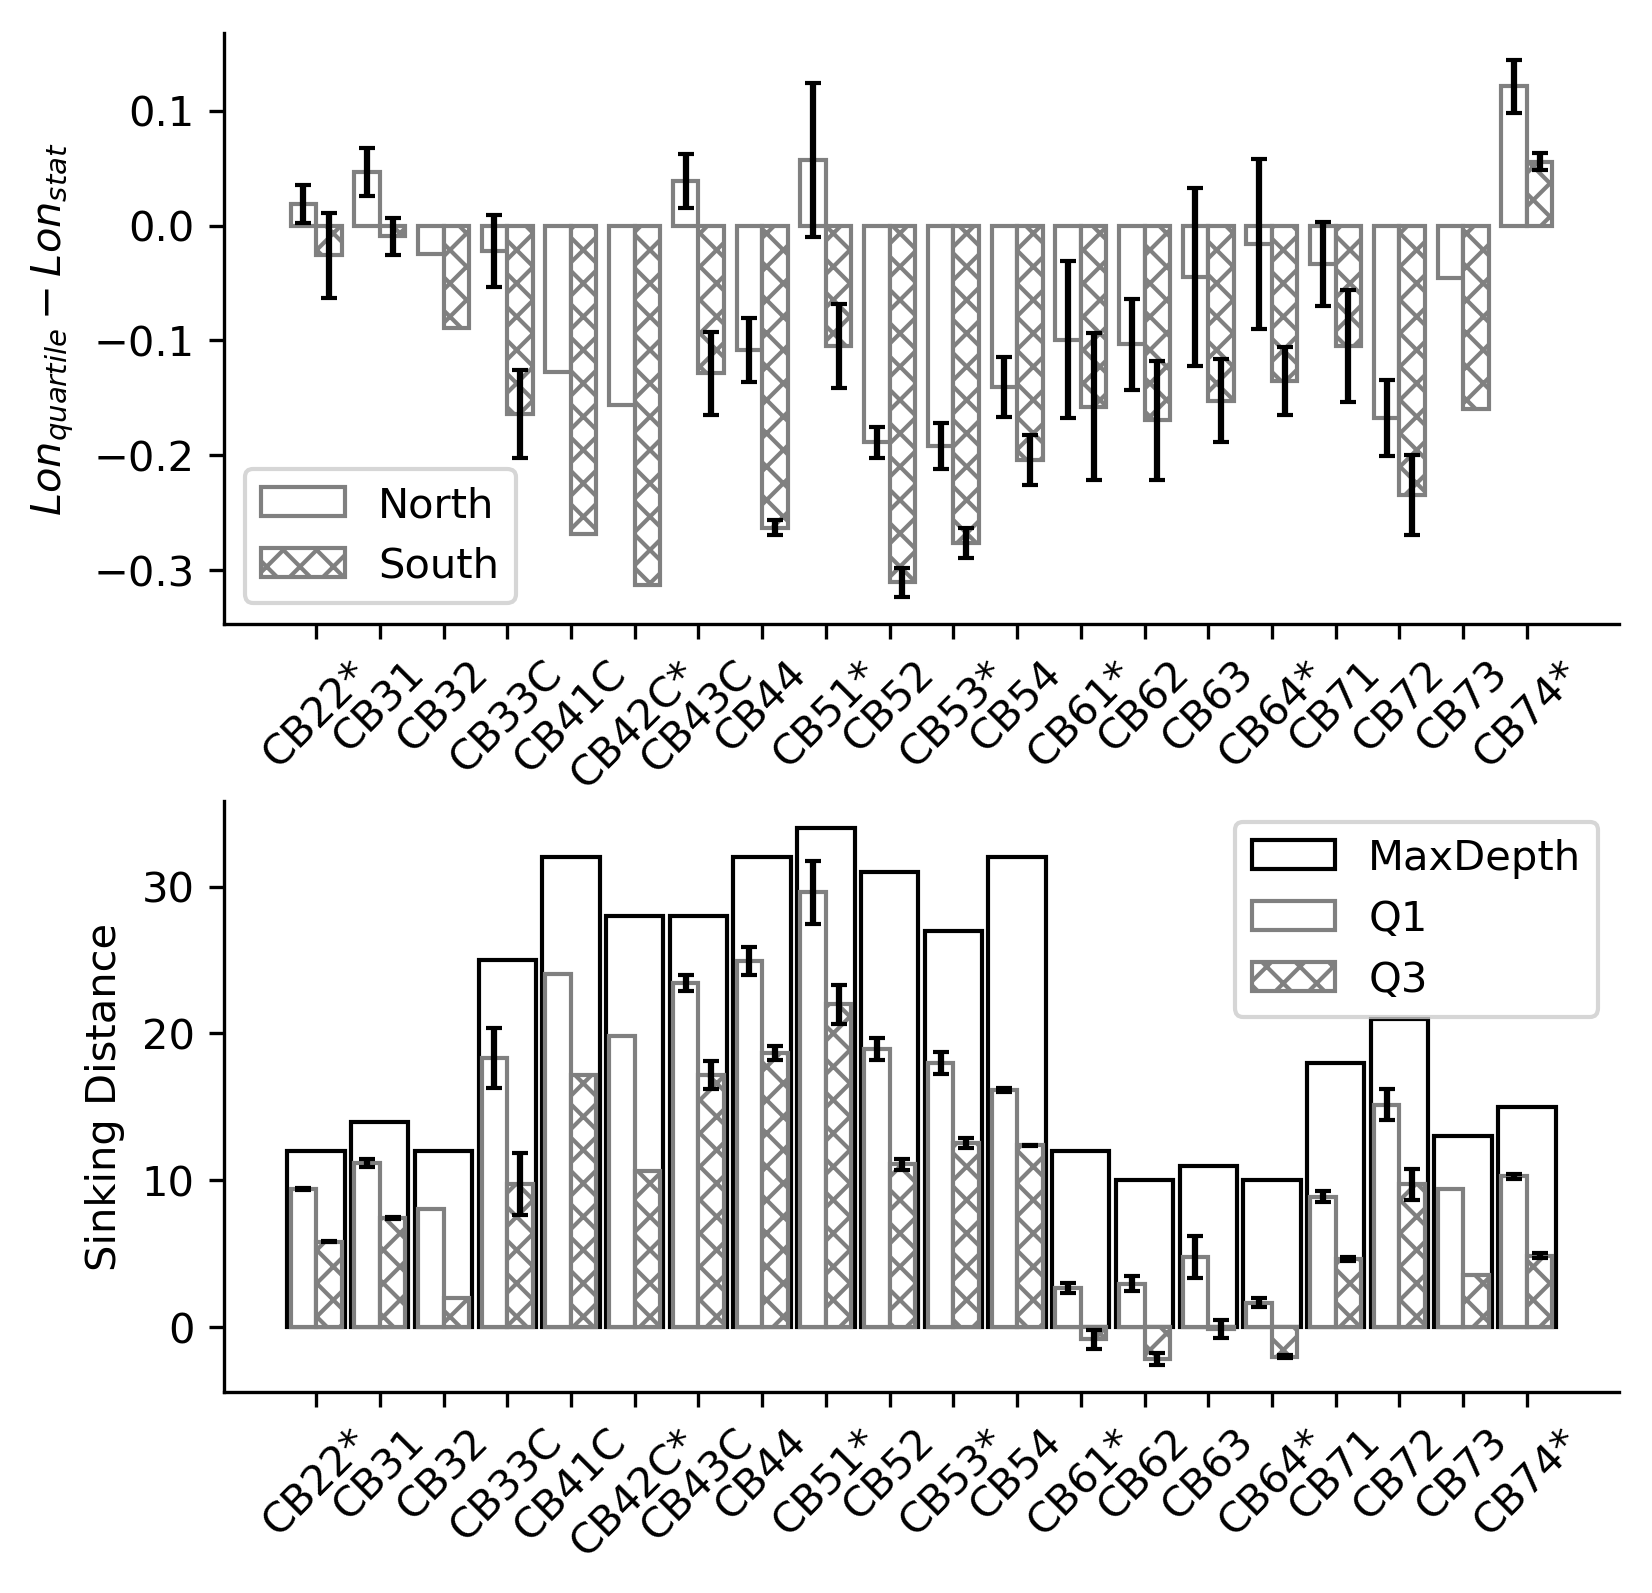

In [16]:
print(particles_transect_2016.columns)
particles2016srt =  particles_transect_2016.sort_values(by=['StationName', 'DateMMDDYY', 'DepthName'])

quant_cols = ['sum_upwelling', 'sum_downwelling', 'up_lim', 'down_lim', 'total_depth']
for qc in quant_cols:
    particles2016srt[qc] = particles2016srt[qc].astype(np.float64)
    
updown_df = particles2016srt.loc[:, quant_cols + ['StationName']].groupby('StationName').agg([np.mean, np.std])

quant_cols2 = ['south_lim', 'north_lim', 'east_lim', 'west_lim']
for qc2 in quant_cols2:
    particles2016srt[qc2] = particles2016srt[qc2].astype(np.float64)

allround_df = particles2016srt.loc[:, quant_cols2 + ['StationName']].groupby('StationName').agg([np.mean, np.std])

y1 = allround_df[('south_lim', 'mean')].values
y2 = allround_df[('north_lim', 'mean')].values
y1s = allround_df[('south_lim', 'std')].values
y2s = allround_df[('north_lim', 'std')].values

y3 = updown_df[('up_lim', 'mean')].values
y4 = updown_df[('down_lim', 'mean')].values
y3s = updown_df[('up_lim', 'std')].values
y4s = updown_df[('down_lim', 'std')].values
y5 = abs(updown_df[('total_depth', 'mean')]).values


xlab  = np.array(list(updown_df.index) + ['abcdef'] )
for xlb_2 in ['CB22', 'CB42C', 'CB51', 'CB53', 'CB61', 'CB64', 'CB74']:
    xlab[xlab == xlb_2] = xlb_2 + "*"
xlab = xlab[:-1]

x12 = np.array(list(range(1,len(y1)+1)))

fig = plt.figure(figsize=(6, 6), dpi=300)
ax1, ax2 = fig.subplots(2, 1, sharex=True)

ax1.bar(x12-0.2, y2, 0.4, label='North', bottom=[0]*len(y2), color='white', edgecolor='grey',
        yerr=y2s, ecolor='black', capsize=2)
ax1.bar(x12+0.2, y1, 0.4, label='South', bottom=[0]*len(y2), color='white', edgecolor='grey', hatch='xxx',
        yerr=y1s, ecolor='black', capsize=2)
ax1.set_ylabel(r'$Lon_{quartile} - Lon_{stat}$')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticks(x12)
ax1.set_xticklabels(list(xlab), rotation = 45)
ax1.tick_params(bottom=True, top=False, left=True, right=False, 
                labelbottom=True, labeltop=False, labelleft=True, labelright=False)
ax1.legend()
ax2.bar(x12, y5, 0.9, label='MaxDepth', bottom=[0]*len(y4), color='white', edgecolor='black')
ax2.bar(x12-0.2, y3, 0.4, label='Q1', bottom=[0]*len(y3), color='white', edgecolor='grey',
        yerr=y3s, ecolor='black', capsize=2)
ax2.bar(x12+0.2, y4, 0.4, label='Q3', bottom=[0]*len(y4), color='white', edgecolor='grey', hatch='xxx',
        yerr=y4s, ecolor='black', capsize=2)


ax2.set_ylabel('Sinking Distance')
ax2.set_xticks(x12)
ax2.set_xticklabels(list(xlab), rotation = 45)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.legend()
plt.subplots_adjust(hspace=0.3)
plt.show()


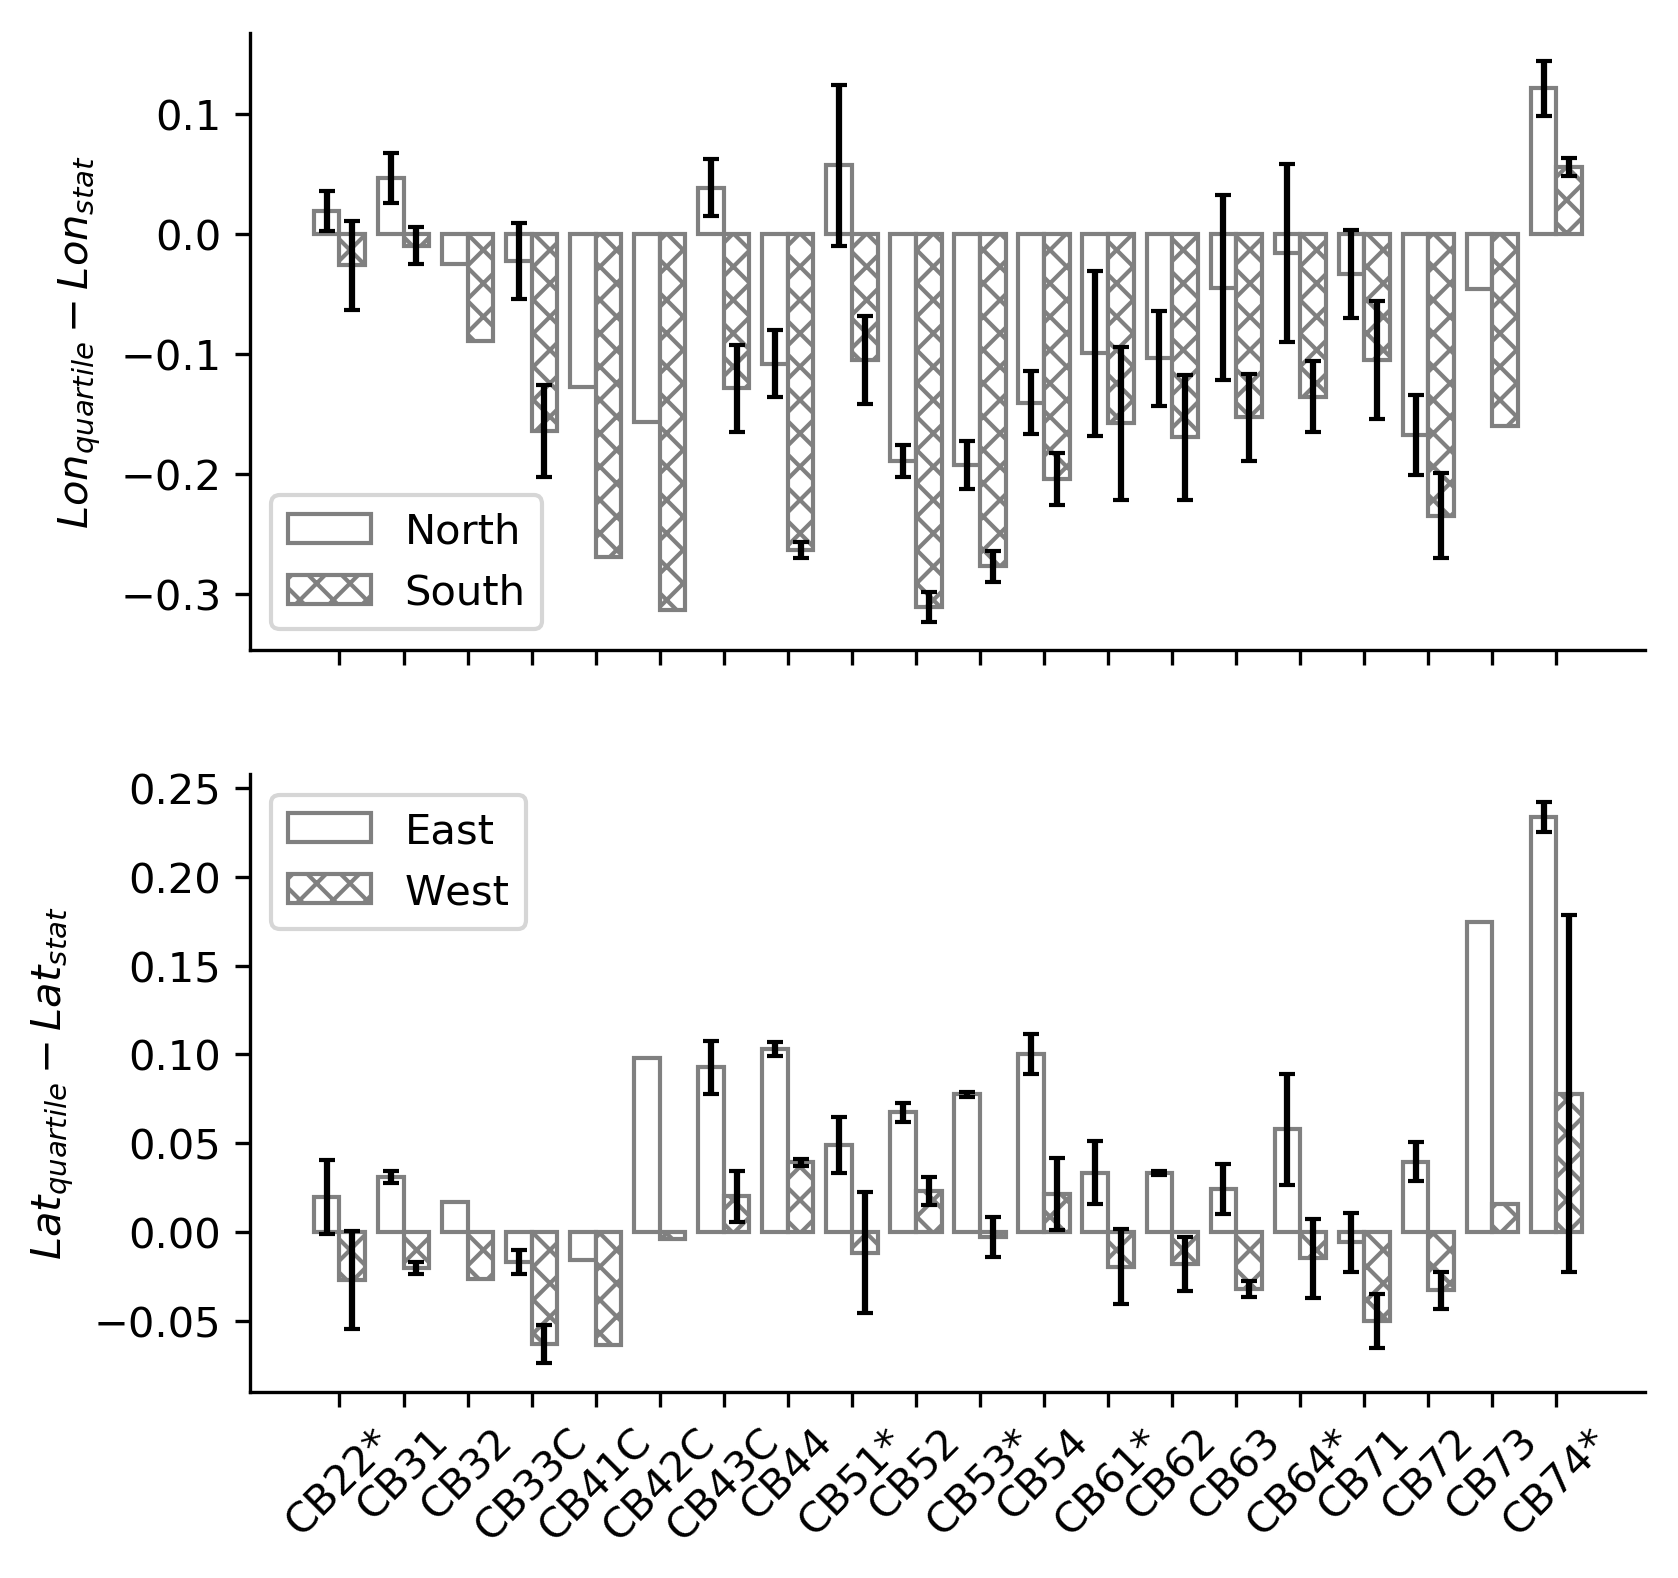

In [17]:
quant_cols2 = ['south_lim', 'north_lim', 'east_lim', 'west_lim']
for qc2 in quant_cols2:
    particles2016srt[qc2] = particles2016srt[qc2].astype(np.float64)

allround_df = particles2016srt.loc[:, quant_cols2 + ['StationName']].groupby('StationName').agg([np.mean, np.std])

y1 = allround_df[('south_lim', 'mean')].values
y2 = allround_df[('north_lim', 'mean')].values
y1s = allround_df[('south_lim', 'std')].values
y2s = allround_df[('north_lim', 'std')].values

y3 = allround_df[('east_lim', 'mean')].values
y4 = allround_df[('west_lim', 'mean')].values
y3s = allround_df[('east_lim', 'std')].values
y4s = allround_df[('west_lim', 'std')].values

xlab  = np.array(list(allround_df.index))
for xlb_2 in ['CB22', 'CB42', 'CB51', 'CB53', 'CB61', 'CB64', 'CB74']:
    xlab[xlab == xlb_2] = xlb_2 + "*"
    
x12 = np.array(list(range(1,len(y1)+1)))


fig = plt.figure(figsize=(6, 6), dpi=300)
ax1, ax2 = fig.subplots(2, 1, sharex=True)

ax1.bar(x12-0.2, y2, 0.4, label='North', bottom=[0]*len(y2), color='white', edgecolor='grey',
        yerr=y2s, ecolor='black', capsize=2)
ax1.bar(x12+0.2, y1, 0.4, label='South', bottom=[0]*len(y2), color='white', edgecolor='grey', hatch='xxx',
        yerr=y1s, ecolor='black', capsize=2)
ax1.set_ylabel(r'$Lon_{quartile} - Lon_{stat}$')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticks(x12)
ax1.set_xticklabels(list(xlab), rotation = 45)
#ax1.tick_params(bottom=False, top=False, left=True, right=False, 
#                labelbottom=False, labeltop=False, labelleft=True, labelright=False)
ax1.legend()
ax2.bar(x12-0.2, y3, 0.4, label='East', bottom=[0]*len(y3), color='white', edgecolor='grey',
        yerr=y3s, ecolor='black', capsize=2)
ax2.bar(x12+0.2, y4, 0.4, label='West', bottom=[0]*len(y4), color='white', edgecolor='grey', hatch='xxx',
        yerr=y4s, ecolor='black', capsize=2)
ax2.set_ylabel(r'$Lat_{quartile} - Lat_{stat}$')
ax2.set_xticks(x12)
ax2.set_xticklabels(list(xlab), rotation = 45)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.legend()
plt.show()


In [19]:
station_groups = {1: ['CB22', 'CB31'],
                  2: ['CB32', 'CB33C', 'CB41C', 'CB42C'],
                  3: ['CB43C', 'CB44'],
                  4: ['CB51', 'CB52'],
                  5: ['CB54', 'CB53', 'CB71'],
                  6: ['CB64', 'CB62', 'CB61', 'CB63'],
                  7: ['CB72', 'CB73', 'CB74']}

station_groups

{1: ['CB22', 'CB31'],
 2: ['CB32', 'CB33C', 'CB41C', 'CB42C'],
 3: ['CB43C', 'CB44'],
 4: ['CB51', 'CB52'],
 5: ['CB54', 'CB53', 'CB71'],
 6: ['CB64', 'CB62', 'CB61', 'CB63'],
 7: ['CB72', 'CB73', 'CB74']}

In [20]:
env_data['StatName'] = pd.Series()

for group_num, group_memb in station_groups.items():
    gbool = env_data['StationName'].isin(group_memb)
    print(group_num, group_memb, 'has', gbool.sum(), 'total samples')
    env_data.loc[gbool,'StatName'] = group_num

statdat = env_data[['StationName', 'StatName', 'Latitude', 'Longitude']].groupby('StationName').agg(['mean', 'count'])
statdat.columns = statdat.columns.droplevel()

statdat.columns = ['StationGroup', 'NumSamples', 'Lat', 'x', 'Lon', 'y']
statdat.drop(['x', 'y'], axis=1, inplace=True)
statdat

1 ['CB22', 'CB31'] has 26 total samples
2 ['CB32', 'CB33C', 'CB41C', 'CB42C'] has 39 total samples
3 ['CB43C', 'CB44'] has 28 total samples
4 ['CB51', 'CB52'] has 12 total samples
5 ['CB54', 'CB53', 'CB71'] has 52 total samples
6 ['CB64', 'CB62', 'CB61', 'CB63'] has 50 total samples
7 ['CB72', 'CB73', 'CB74'] has 29 total samples


/Users/login/miniconda3/envs/skbio2/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


,StationGroup,NumSamples,Lat,Lon
StationName,,,,
CB22,1.0,16,39.34873,-76.17579
CB31,1.0,10,39.24950,-76.24050
CB32,2.0,9,39.16369,-76.30631
CB33C,2.0,18,38.99596,-76.35967
CB41C,2.0,3,38.82593,-76.39945
CB42C,2.0,9,38.64618,-76.42127
CB43C,3.0,12,38.55505,-76.42794
CB44,3.0,16,38.41457,-76.34565
CB51,4.0,9,38.31870,-76.29215


In [ ]:
all_particles = pd.concat(particle_chunks16.values(), axis=0, sort=True, verify_integrity=True)

part_data = {}
for stat_group_i in statdat.StationGroup.unique():
    stat_group_names = list(statdat[statdat.StationGroup == stat_group_i].index)
    stat_group_bool = particles_transect_2016.StationName.isin(stat_group_names)
    stat_group_ixs = list(particles_transect_2016[stat_group_bool].index)
    print("Group", int(stat_group_i), ":", stat_group_names)
    print("Row #s:", stat_group_ixs)

    stat_grp_particles = pd.concat([particle_chunks16[i] for i in stat_group_ixs], 
                                    axis=0, sort=True, verify_integrity=True)

    print("N particles:", len(stat_grp_particles))
    x_pos = stat_grp_particles['lat']# - ap_m['lat']) #/ap_sd['x_km']
    y_pos = stat_grp_particles['lon']# - ap_m['lon']) #/ap_sd['y_km']
    xy_vec = np.sqrt(x_pos**2 + y_pos**2)
    dist_lims = np.percentile(xy_vec, [25, 75])
    x_pos = x_pos[(xy_vec > dist_lims[0]) & (xy_vec < dist_lims[1])]
    y_pos = y_pos[(xy_vec > dist_lims[0]) & (xy_vec < dist_lims[1])]
    part_data[int(stat_group_i)] = {'x': x_pos, 'y': y_pos, 
                               'sx': statdat.loc[stat_group_names, 'Lat'],
                               'sy': statdat.loc[stat_group_names, 'Lon'],
                               'l': "Group{}".format(int(stat_group_i))}

import seaborn as sns
np.random.seed(10)
sns.set_style("whitegrid")

#sns.set(color_codes=True, font_scale=1)
kde_f, kde_ax = plt.subplots(figsize=(6,8), dpi=150)
#kde_ax.tick_params(axis='both', which='major', labelsize=22)
ax1 = sns.kdeplot(part_data[1]['y'], part_data[1]['x'], cmap="Reds", shade=True, shade_lowest=False, 
                  alpha=0.7, ax=kde_ax)
kde_ax.scatter(x=part_data[1]['sy'], y=part_data[1]['sx'], c='red', edgecolors='k')

ax2 = sns.kdeplot(part_data[2]['y'], part_data[2]['x'], cmap="Greens", shade=True, shade_lowest=False, 
                  alpha=0.7, ax=kde_ax)
kde_ax.scatter(x=part_data[2]['sy'], y=part_data[2]['sx'], c='green', edgecolors='k')

ax3 = sns.kdeplot(part_data[3]['y'], part_data[3]['x'], cmap="Blues", shade=True, shade_lowest=False, 
                  alpha=0.7, ax=kde_ax)
kde_ax.scatter(x=part_data[3]['sy'], y=part_data[3]['sx'], c='blue', edgecolors='k')

ax4 = sns.kdeplot(part_data[4]['y'], part_data[4]['x'], cmap="Greys", shade=True, shade_lowest=False, 
                  alpha=0.7, ax=kde_ax)
kde_ax.scatter(x=part_data[4]['sy'], y=part_data[4]['sx'], c='grey', edgecolors='k')

ax5 = sns.kdeplot(part_data[5]['y'], part_data[5]['x'], cmap="Purples", shade=True, shade_lowest=False, 
                  alpha=0.7, ax=kde_ax)
kde_ax.scatter(x=part_data[5]['sy'], y=part_data[5]['sx'], c='purple', edgecolors='k')

ax6 = sns.kdeplot(part_data[6]['y'], part_data[6]['x'], cmap="Oranges", shade=True, shade_lowest=False, 
                  alpha=0.7, ax=kde_ax)
kde_ax.scatter(x=part_data[6]['sy'], y=part_data[6]['sx'], c='orange', edgecolors='k')

#kde_ax.spines['right'].set_visible(False)
#kde_ax.spines['top'].set_visible(False)
kde_ax.set_xlim((-77, -75))
kde_ax.set_ylim((36.75, 39.75))


m2 = Basemap(llcrnrlat=36.75,urcrnrlat=39.75,llcrnrlon=-77,urcrnrlon=-75, resolution='i', ax=kde_ax)
m2.drawcoastlines(linewidth=0.5)
m2.fillcontinents(color='lightgrey',lake_color='white')
m2.drawparallels(np.arange(36.5,40,0.5), labels=[True,True,False,False], dashes=[2,2])
m2.drawmeridians(np.arange(-78.,-74,0.5), labels=[False,False,False,True], dashes=[2,2])
m2.drawmapboundary(fill_color='white')

plt.show()


In [21]:
if env_data.index.name != 'SampleID':
    env_data = env_data.set_index('SampleID')

In [ ]:
f = "~/Google Drive/SiYi_Xiaotong_Materials/bray_curtis_betadiversity.txt"
bd_df = pd.read_csv(f, sep="\t", index_col=0)
bd_df.columns = [i.replace("_wu", "") for i in bd_df.columns]

sn_df = pd.DataFrame(index=list(range(1,7)),
                     columns=list(range(1,7)))

for i in sn_df.index:
    for j in sn_df.index:
        clust_ixs = env_data[env_data.StatName == i].index
        clust_jxs = env_data[env_data.StatName == j].index
        sn_df.loc[i, j] = bd_df.loc[clust_ixs, clust_jxs].mean().mean()

score_c =  []
for i in sn_df.index:
    v = sn_df.iloc[i-1, i-1]
    j = list(sn_df.iloc[i-1,:])
    j.remove(v)
    l = min(j)
    print(i, round(v/l, 3))
    score_c.append(v/l)
    
print(sum(score_c))  

In [ ]:
# ['CB72', 'CB73', 'CB74'] 5.739730923390547
#['CB63', 'CB73', 'CB74'] : 5.811574898837427
#73 and 74 alone : 5.713039267650133

In [22]:
import matplotlib as mpl
print(particles2016.DateMMDDYY.unique())
date_range = ['71316', '71116', '71216']
sub2016_1 = particles_transect_2016[particles_transect_2016.DateMMDDYY.isin(date_range)]
station_set_3 = list(particles_transect_2016.StationName.unique())

sub2016_jul = sub2016_1[sub2016_1.StationName.isin(station_set_3)]

date_range_2 = ['81016', '81216', '80816', '80916']
sub2016_2 = particles_transect_2016[particles_transect_2016.DateMMDDYY.isin(date_range_2)]
sub2016_aug = sub2016_2[sub2016_2.StationName.isin(station_set_3)]
mlp_colors = list(mpl.rcParams['axes.prop_cycle']) * 5



[62716. 71316. 72516. 71216. 71116. 81016. 83116. 81216. 80916. 83016.
 82916. 80816.]


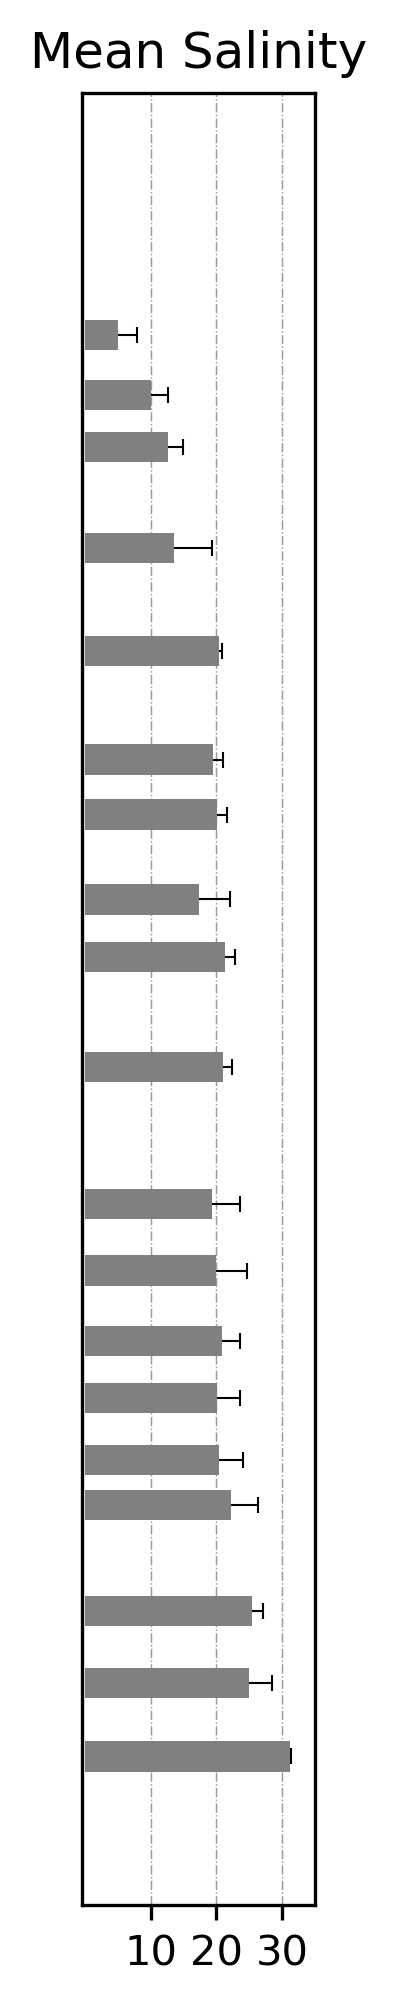

In [23]:
outp = '/Volumes/KeithSSD/CB_V4/otu_data/mixing_data'
outf = "2016_transect_mixing_data_products.txt"
particles_transect_2016.to_csv(os.path.join(outp, outf), sep="\t")

latsal_df = env_data[['SALINITY', 'Latitude']].groupby("Latitude").agg([np.mean, np.std])


fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(1, 8), dpi=300)
axes.set_title('Mean Salinity')
axes.set_label('ppt')
axes.set_xticks([10, 20, 30])
axes.set_xticklabels(['10', '20', '30'])
axes.set_yticks([])
axes.set_yticklabels([])
axes.set_xlim((-0.45, 35))
axes.set_ylim((36.75, 39.75))
axes.grid(color='k', alpha=0.4, ls = '-.', lw = 0.35, axis='x')
axes.barh(y=latsal_df.index, width=latsal_df.loc[:, ('SALINITY', 'mean')],
          xerr=latsal_df.loc[:, ('SALINITY', 'std')], height=0.05, align='center', 
          zorder=10, color='grey', ecolor='k', error_kw={'elinewidth':0.5, 'capsize':2.0, 'capthick':0.5})
plt.show()

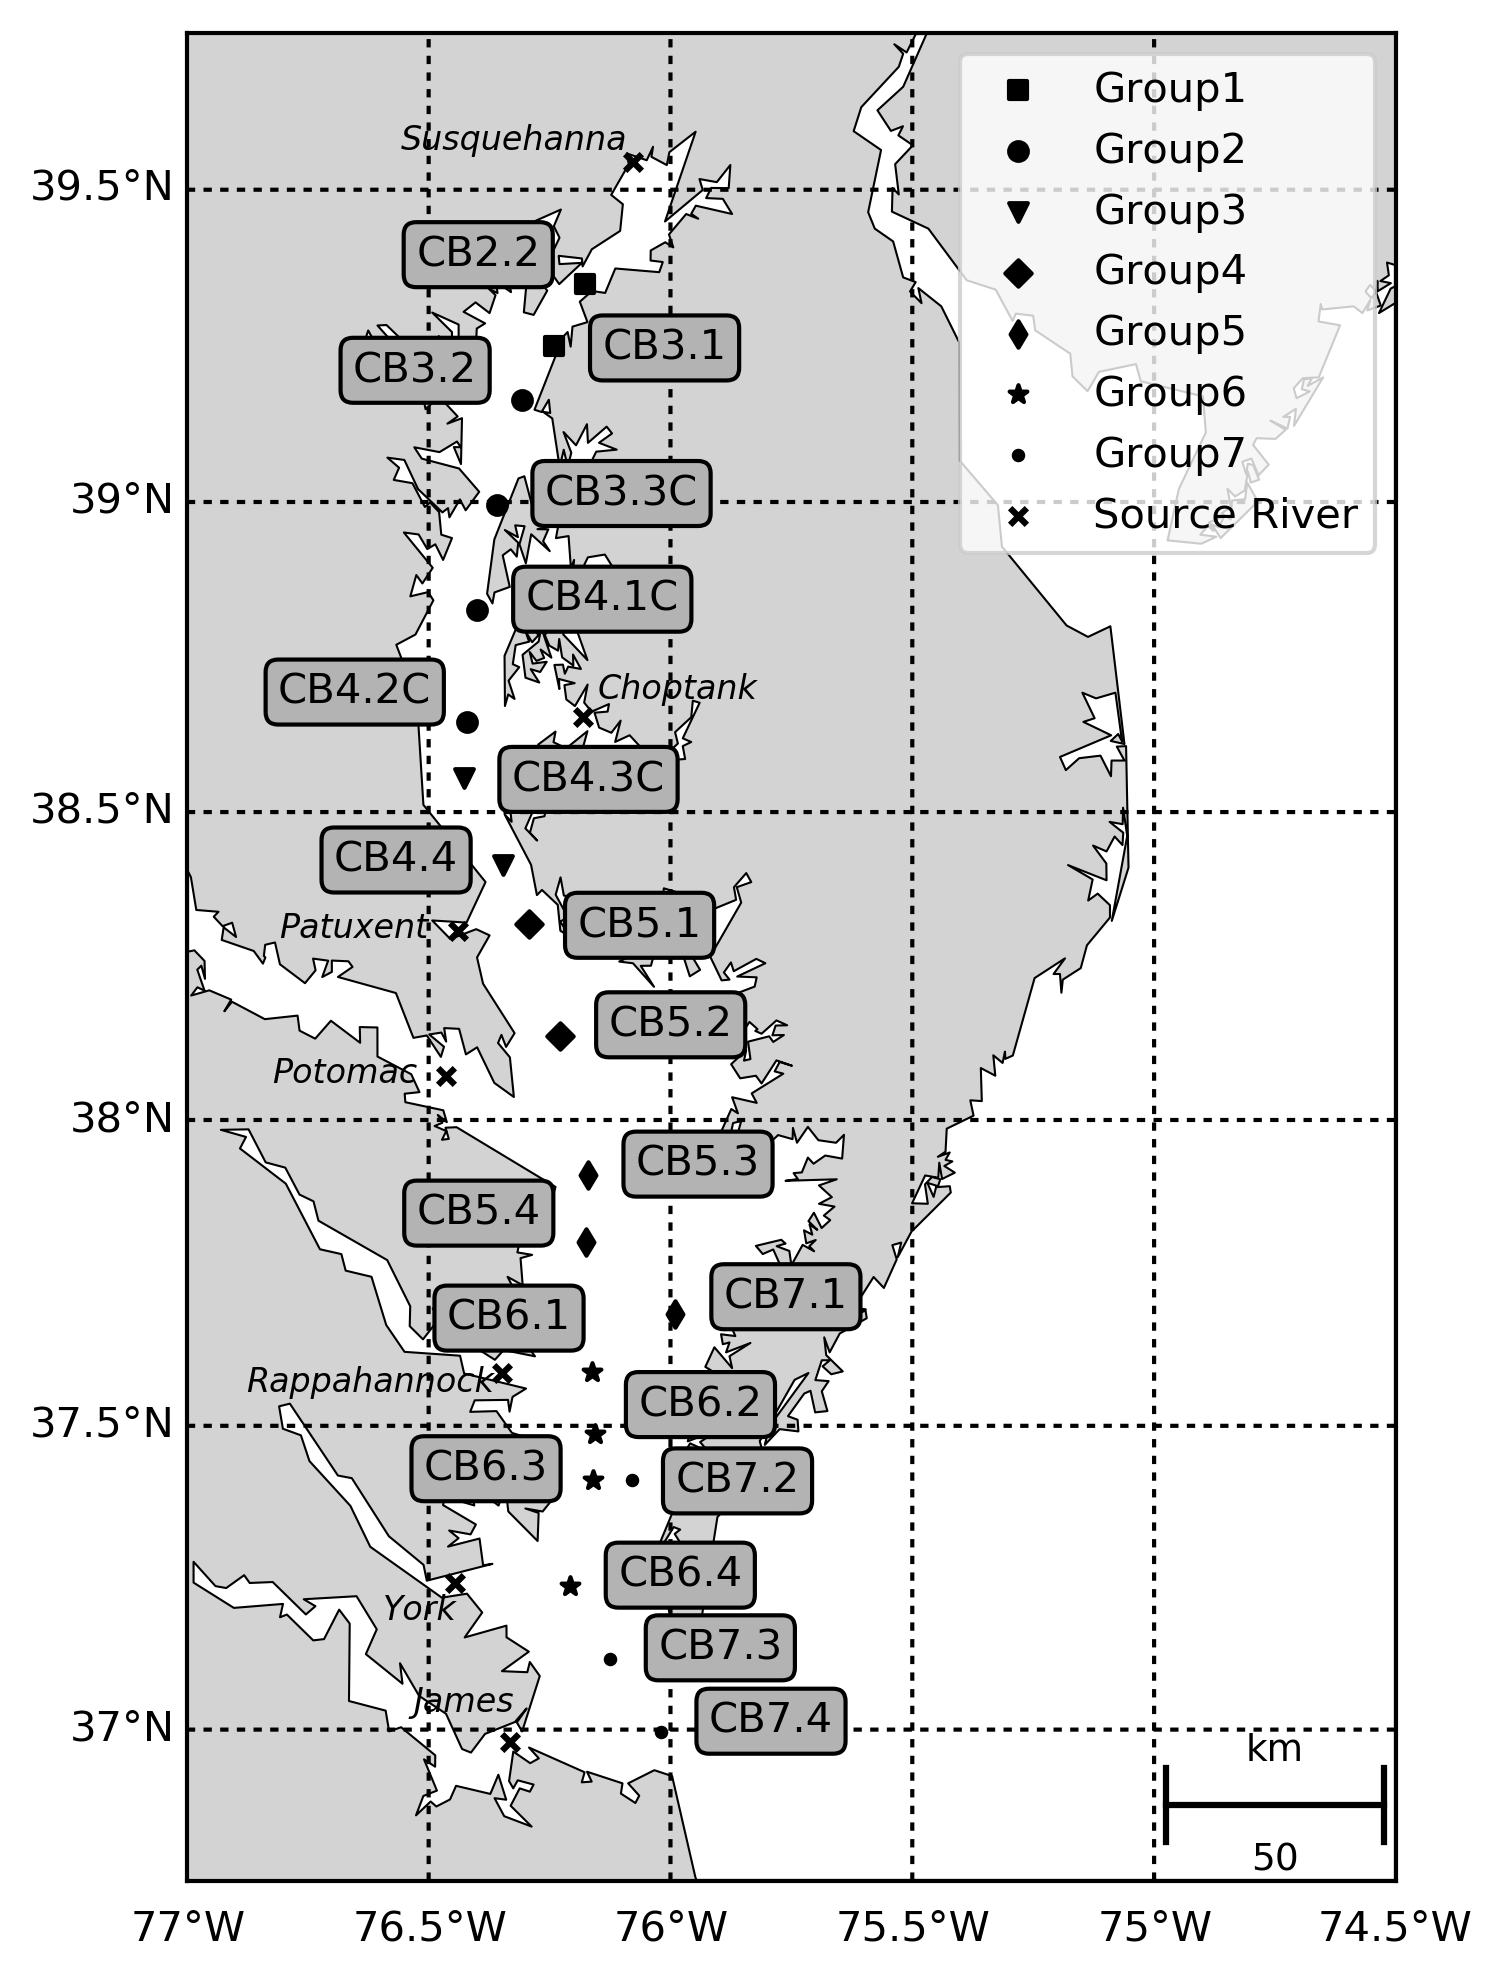

In [46]:
rl = ['Susquehanna', 'Potomac', 'Rappahannock', 'York', 'James', 'Patuxent', 'Choptank']
rx = [-76.077185, -76.463744, -76.348354, -76.445584, -76.332430, -76.438581, -76.179932]
ry = [39.544954, 38.072184, 37.587024, 37.241443, 36.980040, 38.307507, 38.654235]

mpl.rcParams.update(mpl.rcParamsDefault)

font = {'size': 10}

mpl.rc('font', **font)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 8), dpi=300)
m = Basemap(llcrnrlat=36.75,urcrnrlat=39.75,llcrnrlon=-77,urcrnrlon=-74.5, resolution='i', ax=axes,
           projection='merc')
m.drawcoastlines(linewidth=0.5)
m.fillcontinents(color='lightgrey',lake_color='white')
m.drawparallels(np.arange(36.5,40,0.5),labels=[True,False,False,False], dashes=[2,2])
m.drawmeridians(np.arange(-78.,-74,0.5), labels=[False,False,False,True], dashes=[2,2])
m.drawmapboundary(fill_color='white')
#m.drawcountries(linewidth=1.5, linestyle='solid', color='k' ) 
#m.drawstates(linewidth=1.5, linestyle='solid', color='k')
#m.drawrivers(linewidth=2, linestyle='solid', color='white')
m.drawmapscale(lon=-74.75, lat=36.875, lon0=-75.25, lat0=36.875, length=50)

marker_list = ['s', 'o', 'v', 'D', 'd', '*', '.']
for idx_ in statdat.StationGroup.unique():
    this_col = mlp_colors[int(idx_)]['color']
    substat = statdat[statdat.StationGroup == idx_].copy()
    subx, suby = m(substat['Lon'].values, substat['Lat'].values)
    m.scatter(x=subx, y=suby, s=20, c='k', label="Group"+str(int(idx_)),
              marker=marker_list[int(idx_)-1], zorder=10)

lrx, lry = m(rx, ry)
m.scatter(x=lrx, y=lry, s=16, c='k', label="Source River", marker='x', zorder=10)

lrx0, lry0 = m(rx[0]-0.48, ry[0]+0.02)
axes.annotate(rl[0], (lrx0, lry0), size=8, style='italic')

lrx6, lry6 = m(rx[6]+0.03, ry[6]+0.03)
axes.annotate(rl[6], (lrx6, lry6), size=8, style='italic')

lrx5, lry5 = m(rx[5]-0.37, ry[5]-0.01)
axes.annotate(rl[5], (lrx5, lry5), size=8, style='italic')

lrx2, lry2 = m(rx[2]-0.53, ry[2]-0.03)
axes.annotate(rl[2], (lrx2, lry2), size=8, style='italic')

lrx1, lry1 = m(rx[1]-0.36, ry[1]-0.01)
axes.annotate(rl[1], (lrx1, lry1), size=8, style='italic')

lrx3, lry3 = m(rx[3]-0.15, ry[3]-0.06)
axes.annotate(rl[3], (lrx3, lry3), size=8, style='italic')

lrx4, lry4 = m(rx[4]-0.20, ry[4]+0.05)
axes.annotate(rl[4], (lrx4, lry4), size=8, style='italic')

bbox_args = dict(boxstyle="round", fc="0.7")
for row in statdat.index:
    rownew = row[:3] + '.' + row[3:]
    realx, realy = statdat['Lon'][row], statdat['Lat'][row]
    
    if row == 'CB63':
        subx, suby = m(realx-0.35, realy)
    elif row == 'CB61':
        subx, suby = m(realx-0.3, realy+0.07)
    elif row in ['CB22', 'CB32', 'CB54']:
        subx, suby = m(realx-0.35, realy+0.03)
    elif row in ['CB44']:
        subx, suby = m(realx-0.35, realy-0.01)
    elif row in ['CB42C']:
        subx, suby = m(realx-0.39, realy+0.03)
    elif row in ['CB31']:
        subx, suby = m(realx+0.1, realy-0.02)
    elif row in ['CB32', 'CB43C', 'CB51']:
        subx, suby = m(realx+0.1, realy-0.02)
    elif row in ['CB71']:
        subx, suby = m(realx+0.1, realy+0.01)
    elif row in ['CB72']:
        subx, suby = m(realx+0.09, realy-0.02)
    elif row in ['CB62']:
        subx, suby = m(realx+0.09, realy+0.03)
    else:
        subx, suby = m(realx+0.1, realy)
    
    allnotes = "{}, n={}".format(rownew, int(statdat['NumSamples'][row]))
    axes.annotate(rownew, (subx, suby), bbox=bbox_args, size=10)
    
axes.legend(loc='upper right')
plt.show()

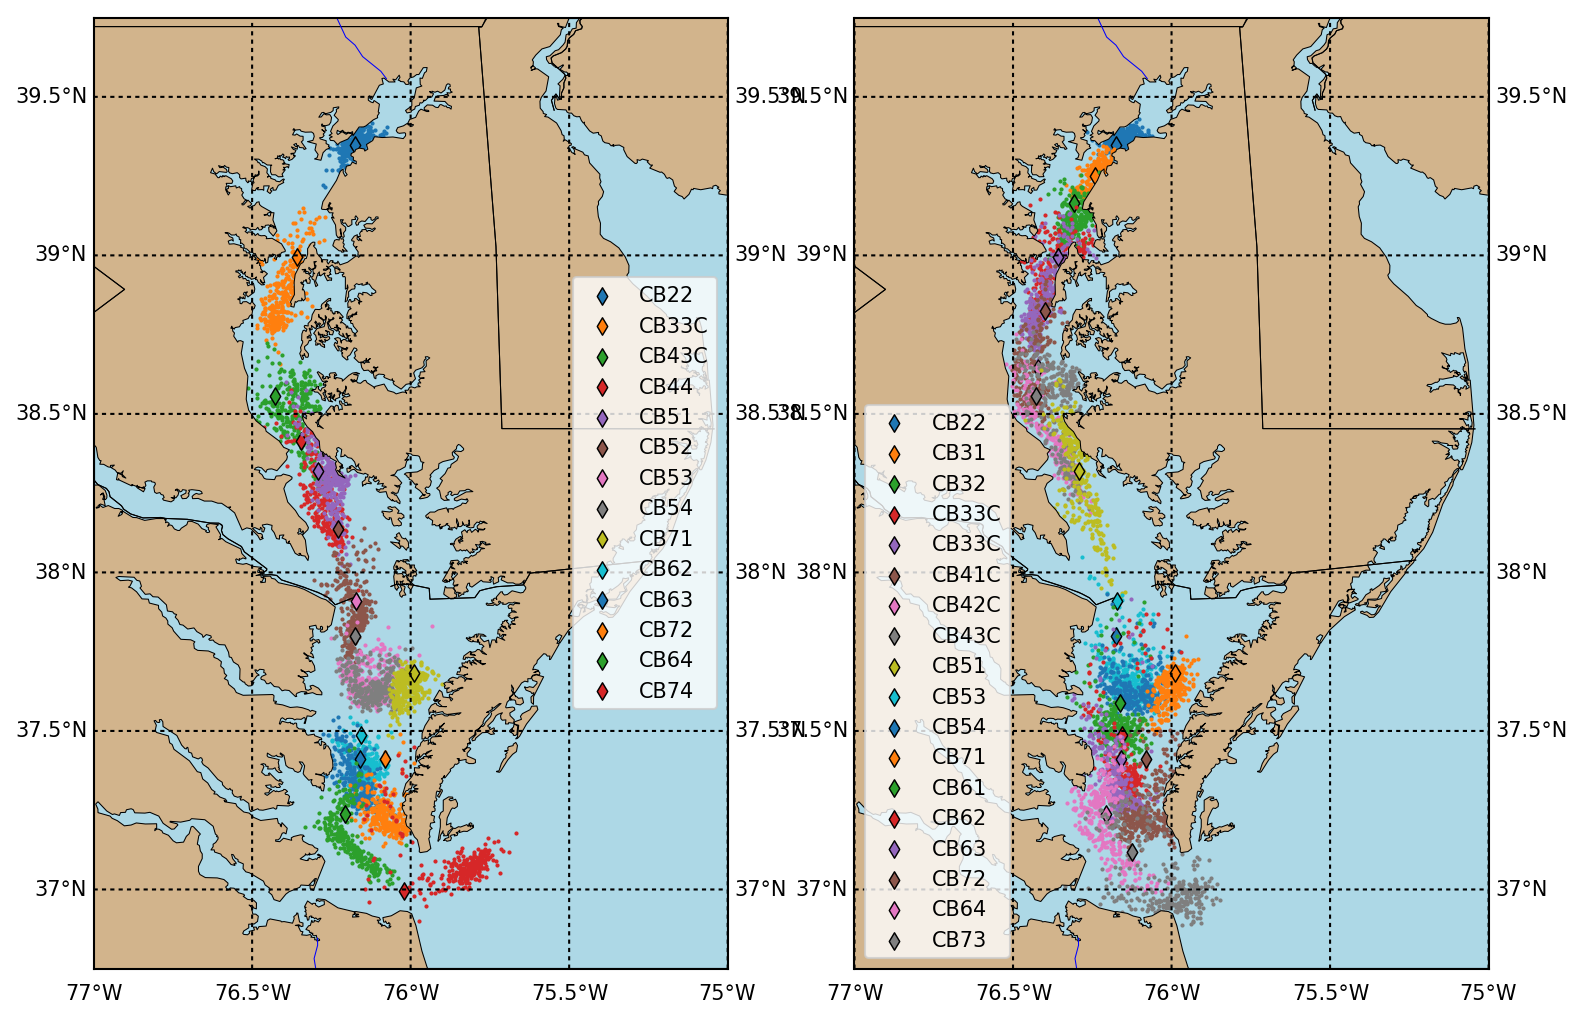

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 10), dpi=150)
m = Basemap(llcrnrlat=36.75,urcrnrlat=39.75,llcrnrlon=-77,urcrnrlon=-75, resolution='h', ax=axes[0])
m.drawcoastlines(linewidth=0.5)
m.fillcontinents(color='tan',lake_color='lightblue')
# draw parallels and meridians.
m.drawparallels(np.arange(36.5,40,0.5),labels=[True,True,False,False], dashes=[2,2])
m.drawmeridians(np.arange(-78.,-74,0.5), labels=[False,False,False,True], dashes=[2,2])
m.drawmapboundary(fill_color='lightblue')
m.drawcountries(linewidth=2, linestyle='solid', color='k' ) 
m.drawstates(linewidth=0.5, linestyle='solid', color='k')
m.drawrivers(linewidth=0.5, linestyle='solid', color='blue')

for idx_ in range(len(sub2016_jul)):
    this_col = mlp_colors[idx_]['color']
    idx_no = sub2016_jul.index[idx_]
    statname = sub2016_jul.loc[idx_no, 'StationName']
    m.scatter(x=particle_chunks16[idx_no]['lon'], 
              y=particle_chunks16[idx_no]['lat'], s=1, c=this_col, label=None)
    m.scatter(x = stat_latlon.loc[statname, 'Longitude'], 
              y = stat_latlon.loc[statname, 'Latitude'], 
              s=35, marker='d', edgecolor='k', linewidths=0.7, c=this_col, label=statname)

m2 = Basemap(llcrnrlat=36.75,urcrnrlat=39.75,llcrnrlon=-77,urcrnrlon=-75, resolution='h', ax=axes[1])
m2.drawcoastlines(linewidth=0.5)
m2.fillcontinents(color='tan',lake_color='lightblue')
m2.drawparallels(np.arange(36.5,40,0.5), labels=[True,True,False,False], dashes=[2,2])
m2.drawmeridians(np.arange(-78.,-74,0.5), labels=[False,False,False,True], dashes=[2,2])
m2.drawmapboundary(fill_color='lightblue')
m2.drawcountries(linewidth=2, linestyle='solid', color='k' ) 
m2.drawstates(linewidth=0.5, linestyle='solid', color='k')
m2.drawrivers(linewidth=0.5, linestyle='solid', color='blue')
for idx_ in range(len(sub2016_aug)):
    this_col = mlp_colors[idx_]['color']
    idx_no = sub2016_aug.index[idx_]
    statname = sub2016_aug.loc[idx_no, 'StationName']
    m2.scatter(x=particle_chunks16[idx_no]['lon'], 
               y=particle_chunks16[idx_no]['lat'], s=1, c=this_col, label=None)
    m2.scatter(x = stat_latlon.loc[statname, 'Longitude'], 
              y = stat_latlon.loc[statname, 'Latitude'], 
              s=35, marker='d', edgecolor='k', linewidths=0.7, c=this_col, label=statname)

axes[0].legend()
axes[1].legend()

In [ ]:
import numpy as np

import pandas
import matplotlib.pyplot as plt
from matplotlib import rcParams



rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

plt.ioff()


mean, cov = [0, 2], [(2, 1), (.5, 1)]
x1, y1 = np.random.multivariate_normal(mean, cov, size=50).T

mean, cov = [5, 7], [(3, 2), (7, 1)]
x2, y2 = np.random.multivariate_normal(mean, cov, size=50).T



plt.xlabel("foo", fontsize=22)
plt.ylabel("bar", fontsize=22)
plt.savefig("foo_vs_bar.png")